In [2]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [3]:
def sine_testing():
    """ Sinus fit testing with a self defined estimator. """

    x_axis = np.linspace(0, 25, 75)
    x_axis1 = np.linspace(25, 50, 75)
    x_axis = np.append(x_axis, x_axis1)
    x_nice = np.linspace(x_axis[0],x_axis[-1], 1000)

    mod,params = fitlogic.make_sine_model()
    print('Parameters of the model',mod.param_names,
          ' with the independet variable',mod.independent_vars)

    print(1/(x_axis[1]-x_axis[0]))
    params['amplitude'].value=0.9 + np.random.normal(0,0.4)
    params['frequency'].value=0.1
    params['phase'].value=np.pi*1.0
    params['offset'].value=3.94+np.random.normal(0,0.4)

    data_noisy=(mod.eval(x=x_axis,params=params) + 0.3*np.random.normal(size=x_axis.shape))


    # set the offset as the average of the data
    offset = np.average(data_noisy)

    # level data
    data_level = data_noisy - offset

    # estimate amplitude
    ampl_val = max(np.abs(data_level.min()), np.abs(data_level.max()))

    # calculate dft with zeropadding to obtain nicer interpolation between the
    # appearing peaks.
    dft_x, dft_y = compute_dft(x_axis, data_level, zeropad_num=1)

    plt.figure()
    plt.plot(dft_x, dft_y, label='dft of data')
    plt.xlabel('Frequency')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    stepsize = x_axis[1]-x_axis[0]  # for frequency axis
    frequency_max = np.abs(dft_x[np.log(dft_y).argmax()])

    print(frequency_max)
    print('offset',offset)
#
    # find minimal distance to the next meas point in the corresponding time
    # value
    diff_array = np.ediff1d(x_axis)
    min_x_diff = diff_array.min()

    # if at least two identical values are in the array, then the difference is
    # of course zero, catch that case.
    for tries in range(len(diff_array)):
        if np.isclose(min_x_diff, 0.0):
            index = np.argmin(diff_array)
            diff_array = np.delete(diff_array, index)
            min_x_diff = diff_array.min()

        else:
            if len(diff_array) == 0:
                fitlogic.log.error('The passed x_axis for the sinus estimation contains the same values!'
                                   ' Cannot do the fit!')

                return -1, params
            else:
                min_x_diff = diff_array.min()
            break

    # How many points are used to sample the estimated frequency with min_x_diff:
    iter_steps = int(1/(frequency_max*min_x_diff))
    if iter_steps < 1:
        iter_steps = 1

    sum_res = np.zeros(iter_steps)

    # Procedure: Create sin waves with different phases and perform a summation.
    #            The sum shows how well the sine was fitting to the actual data.
    #            The best fitting sine should be a maximum of the summed time
    #            trace.

    for iter_s in range(iter_steps):
        func_val = ampl_val * np.sin(2*np.pi*frequency_max*x_axis + iter_s/iter_steps *2*np.pi)
        sum_res[iter_s] = np.abs(data_level - func_val).sum()

    plt.figure()
    plt.plot(list(range(iter_steps)), sum_res, label='sum of different phase iteration')
    plt.xlabel('iteration')
    plt.ylabel('summed value')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # The minimum indicates where the sine function was fitting the worst,
    # therefore subtract pi. This will also ensure that the estimated phase will
    # be in the interval [-pi,pi].
    phase = sum_res.argmax()/iter_steps *2*np.pi - np.pi

    mod, params = fitlogic.make_sine_model()

    # values and bounds of initial parameters
    params['amplitude'].set(value=ampl_val)
    params['frequency'].set(value=frequency_max, min=0.0, max=1/(stepsize)*3)
    params['phase'].set(value=phase, min=-np.pi, max=np.pi)
    params['offset'].set(value=offset)

    # perform fit:
    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.plot(x_axis,data_noisy,'ob', label='noisy data')
    plt.plot(x_axis,result.init_fit,'-y', label='initial values')
    plt.plot(x_axis,result.best_fit,'-r',linewidth=2.0, label='actual fit')
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

    plt.show()

Parameters of the model ['amplitude', 'frequency', 'phase', 'offset']  with the independet variable x
2.96
0.0986666666666
offset 4.01809182039


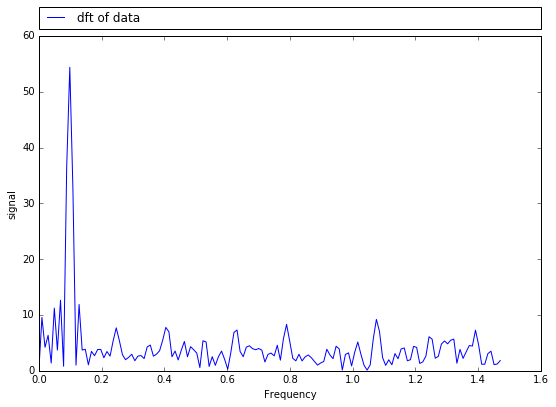

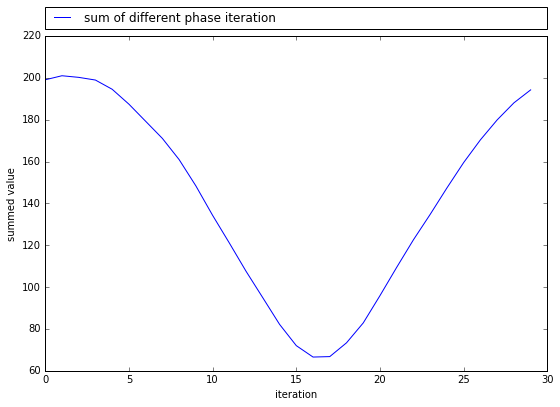

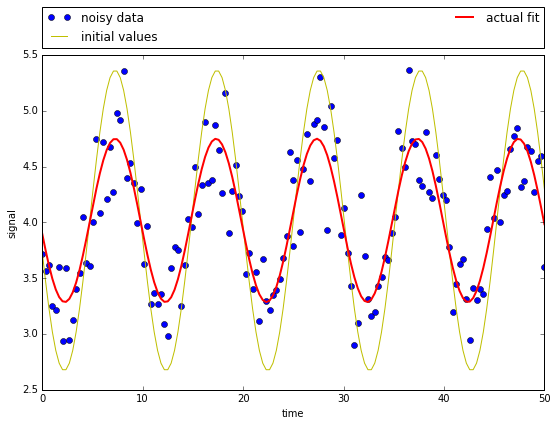

In [4]:
sine_testing()

In [5]:
def sine_testing2():
    """ Sinus fit testing with the direct fit method. """

    x_axis = np.linspace(0, 250, 75)
    x_axis1 = np.linspace(250, 500, 75)
    x_axis = np.append(x_axis, x_axis1)
    x_nice = np.linspace(x_axis[0],x_axis[-1], 1000)

    mod, params = fitlogic.make_sine_model()

    params['phase'].value = np.pi/2 # np.random.uniform()*2*np.pi
    params['frequency'].value = 0.01
    params['amplitude'].value = 1.5
    params['offset'].value = 0.4

    data = mod.eval(x=x_axis, params=params)
    data_noisy = (mod.eval(x=x_axis, params=params) + 1.5 * np.random.normal(size=x_axis.shape))

    update_dict = {}
    update_dict['phase'] = {'vary': False, 'value': np.pi/2.}

    result = fitlogic.make_sine_fit(
        x_axis=x_axis,
        data=data_noisy,
        add_params=update_dict,
        estimator=fitlogic.estimate_sine)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, result.init_fit, label='initial data')
    plt.plot(x_axis, result.best_fit, label='fit data')
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

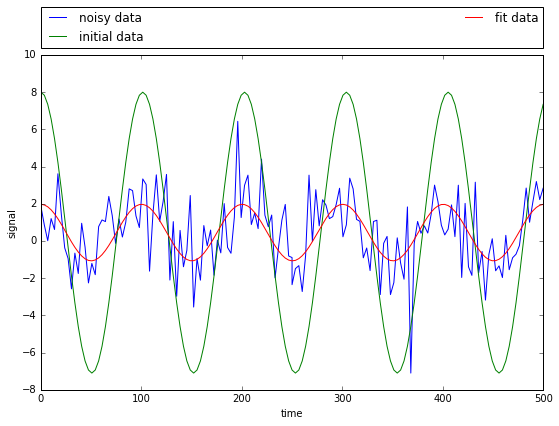

In [6]:
sine_testing2()

In [1]:
def two_sine_offset_testing():
    """ Testing procedure for the estimator for a double sine with offset fit. """

    x_axis = np.linspace(5, 300 ,200)
    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 1
    freq1 = 0.02

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 1
    freq2 = 0.01

    offset = 1

    data = ampl1 * np.sin(2*np.pi*freq1*x_axis +phase1) +ampl2 * np.sin(2*np.pi*freq2*x_axis +phase2) + offset

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*2

    res = qudi_fitting.make_sine_fit(x_axis=x_axis, data=noisy_data)

    data_sub = noisy_data - res.best_fit

    res2 = qudi_fitting.make_sine_fit(x_axis=x_axis, data=data_sub)

    plt.figure()
    plt.plot(x_axis, res.best_fit+res2.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    mod, params = fitlogic.make_sinedouble_model()

    params['s1_amplitude'].set(value=res.params['amplitude'].value)
    params['s1_frequency'].set(value=res.params['frequency'].value)
    params['s1_phase'].set(value=res.params['phase'].value)

    params['s2_amplitude'].set(value=res2.params['amplitude'].value)
    params['s2_frequency'].set(value=res2.params['frequency'].value)
    params['s2_phase'].set(value=res2.params['phase'].value)

    params['offset'].set(value=data.mean())

    result = mod.fit(noisy_data, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print("freq1:", result.params['s1frequency'].value)
    print("freq2:", result.params['s2frequency'].value)

[[Model]]
    (((Model(amplitude_function, prefix='s1_') * Model(bare_sine_function, prefix='s1_')) + (Model(amplitude_function, prefix='s2_') * Model(bare_sine_function, prefix='s2_'))) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 200
    # variables        = 7
    chi-square         = 211.017
    reduced chi-square = 1.093
    Akaike info crit   = 24.724
    Bayesian info crit = 47.812
[[Variables]]
    s1_amplitude:   1.04785336 +/- 0.104772 (10.00%) (init= 1.052326)
    s1_frequency:   0.01997973 +/- 0.000191 (0.95%) (init= 0.02024444)
    s1_phase:       0.32348026 +/- 0.212639 (65.73%) (init= 0.07958806)
    s2_amplitude:   1.00806617 +/- 0.107742 (10.69%) (init= 0.9862898)
    s2_frequency:   0.00984655 +/- 0.000196 (1.99%) (init= 0.009833867)
    s2_phase:       1.48753844 +/- 0.215825 (14.51%) (init= 1.512095)
    offset:         1.12488473 +/- 0.076862 (6.83%) (init= 1.089625)
[[Correlations]] (unreported correlations are

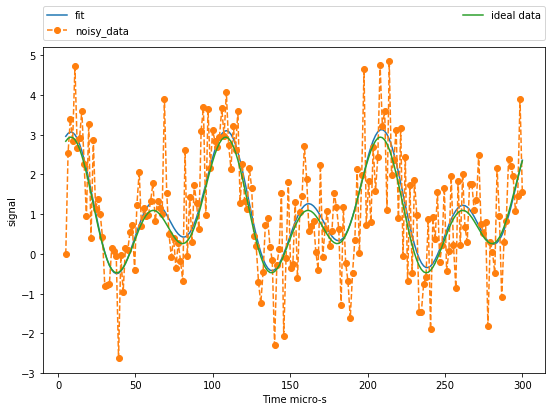

In [4]:
two_sine_offset_testing2()

In [2]:
def two_sine_offset_testing2():
    """ Testing procedure for the implemented two sine with exponential
        decay and offset fit. """

    x_axis = np.linspace(5, 300 ,200)
    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 1
    freq1 = 0.02

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 1
    freq2 = 0.01

    offset = 1

    data = ampl1 * np.sin(2*np.pi*freq1*x_axis +phase1) +ampl2 * np.sin(2*np.pi*freq2*x_axis +phase2) + offset

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*1.0

    result = fitlogic.make_sinedouble_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sinedouble)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())


[[Model]]
    (((Model(amplitude_function, prefix='s1_') * Model(bare_sine_function, prefix='s1_')) + (Model(amplitude_function, prefix='s2_') * Model(bare_sine_function, prefix='s2_'))) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 35
    # data points      = 200
    # variables        = 7
    chi-square         = 188.235
    reduced chi-square = 0.975
    Akaike info crit   = 1.875
    Bayesian info crit = 24.963
[[Variables]]
    s1_amplitude:   1.11937061 +/- 0.100254 (8.96%) (init= 1.149051)
    s1_frequency:   0.01975705 +/- 0.000172 (0.87%) (init= 0.01990403)
    s1_phase:       3.36177738 +/- 0.189050 (5.62%) (init= 3.141593)
    s2_amplitude:   0.86593136 +/- 0.100105 (11.56%) (init= 0.8780784)
    s2_frequency:   0.01027271 +/- 0.000219 (2.14%) (init= 0.01023878)
    s2_phase:       0.20456552 +/- 0.247883 (121.18%) (init= 0.2444436)
    offset:         0.99761864 +/- 0.070746 (7.09%) (init= 1.012998)
[[Correlations]] (unreported correlations are <  

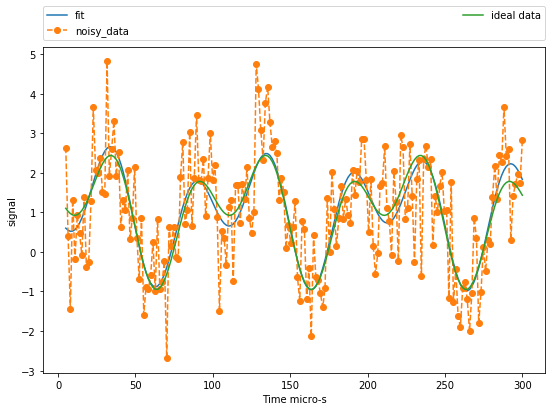

In [3]:
two_sine_offset_testing2()

In [9]:
def three_sine_offset_testing():
    """ Testing procedure for the estimator for a three sine with offset fit. """

    x_axis = np.linspace(5, 300 ,200)

    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 3
    freq1 = 0.03

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 2
    freq2 = 0.01

    phase3 = np.random.uniform()*2*np.pi
    ampl3 = 1
    freq3 = 0.05

    offset = 1.1

    data = (  ampl1 * np.sin(2*np.pi*freq1*x_axis + phase1)
            + ampl2 * np.sin(2*np.pi*freq2*x_axis + phase2)
            + ampl3 * np.sin(2*np.pi*freq3*x_axis + phase3)
            + offset)

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*3

    x_dft1, y_dft1 = compute_dft(x_val=x_axis, y_val=noisy_data, zeropad_num=1)

    plt.figure()
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time (micro-s)')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    res1 = fitlogic.make_sine_fit(x_axis=x_axis, data=noisy_data, estimator=fitlogic.estimate_sine)
    data_sub1 = noisy_data - res1.best_fit

    x_dft2, y_dft2 = compute_dft(x_val=x_axis, y_val=data_sub1, zeropad_num=1)

    res2 = fitlogic.make_sine_fit(x_axis=x_axis, data=data_sub1, estimator=fitlogic.estimate_sine)
    data_sub2 = data_sub1 - res2.best_fit

    res3 = fitlogic.make_sine_fit(x_axis=x_axis, data=data_sub2, estimator=fitlogic.estimate_sine)

    x_dft3, y_dft3 = compute_dft(x_val=x_axis, y_val=data_sub2, zeropad_num=1)

    plt.figure()
    plt.plot(x_dft1, y_dft1, '-', label='noisy_data (3 peaks)')
    plt.plot(x_dft2, y_dft2, '-', label='noisy_data (2 peaks)')
    plt.plot(x_dft3, y_dft3, '-', label='noisy_data (1 peak)')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()


    mod, params = qudi_fitting.make_sinetriple_model()

    params['s1_amplitude'].set(value=res1.params['amplitude'].value)
    params['s1_frequency'].set(value=res1.params['frequency'].value)
    params['s1_phase'].set(value=res1.params['phase'].value)

    params['s2_amplitude'].set(value=res2.params['amplitude'].value)
    params['s2_frequency'].set(value=res2.params['frequency'].value)
    params['s2_phase'].set(value=res2.params['phase'].value)

    params['s3_amplitude'].set(value=res3.params['amplitude'].value)
    params['s3_frequency'].set(value=res3.params['frequency'].value)
    params['s3_phase'].set(value=res3.params['phase'].value)

    params['offset'].set(value=data.mean())

    result = mod.fit(noisy_data, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())

[[Model]]
    ((((Model(amplitude_function, prefix='s1_') * Model(bare_sine_function, prefix='s1_')) + (Model(amplitude_function, prefix='s2_') * Model(bare_sine_function, prefix='s2_'))) + (Model(amplitude_function, prefix='s3_') * Model(bare_sine_function, prefix='s3_'))) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 157
    # data points      = 200
    # variables        = 10
    chi-square         = 1957.384
    reduced chi-square = 10.302
    Akaike info crit   = 476.209
    Bayesian info crit = 509.193
[[Variables]]
    s1_amplitude:   3.22202047 +/- 0.319320 (9.91%) (init= 3.235818)
    s1_frequency:   0.02991739 +/- 0.000189 (0.63%) (init= 0.02987961)
    s1_phase:      -0.11264392 +/- 0.208060 (184.71%) (init=-0.05389727)
    s2_amplitude:   1.48020179 +/- 0.323533 (21.86%) (init= 1.466812)
    s2_frequency:   0.01004612 +/- 0.000419 (4.17%) (init= 0.01004403)
    s2_phase:      -1.54021178 +/- 0.447756 (29.07%) (init=-1.534028)
    s3_amplitude:   1.

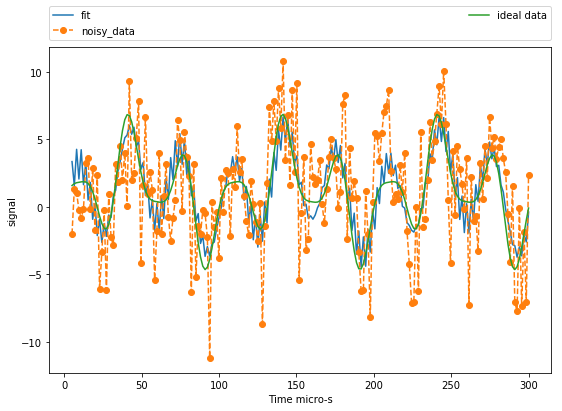

In [11]:
three_sine_offset_testing2()

In [10]:
def three_sine_offset_testing2():
    """ Testing procedure for the implemented three sine with offset fit. """

    x_axis = np.linspace(5, 300 ,200)

    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 3
    freq1 = 0.03

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 2
    freq2 = 0.01

    phase3 = np.random.uniform()*2*np.pi
    ampl3 = 1
    freq3 = 0.05

    offset = 1.1

    data = (ampl1 * np.sin(2*np.pi*freq1*x_axis + phase1) 
            + ampl2 * np.sin(2*np.pi*freq2*x_axis + phase2)
            + ampl3 * np.sin(2*np.pi*freq3*x_axis + phase3)
            + offset)

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*3

    result = fitlogic.make_sinetriple_fit(
            x_axis=x_axis,
            data=noisy_data,
            estimator=fitlogic.estimate_sinetriple)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())

[[Model]]
    ((((Model(amplitude_function, prefix='s1_') * Model(bare_sine_function, prefix='s1_')) + (Model(amplitude_function, prefix='s2_') * Model(bare_sine_function, prefix='s2_'))) + (Model(amplitude_function, prefix='s3_') * Model(bare_sine_function, prefix='s3_'))) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 47
    # data points      = 200
    # variables        = 10
    chi-square         = 1885.003
    reduced chi-square = 9.921
    Akaike info crit   = 468.673
    Bayesian info crit = 501.657
[[Variables]]
    s1_amplitude:   2.54243086 +/- 0.318485 (12.53%) (init= 2.497224)
    s1_frequency:   0.00998478 +/- 0.000237 (2.38%) (init= 0.01001756)
    s1_phase:       1.11510899 +/- 0.264958 (23.76%) (init= 1.080427)
    s2_amplitude:   2.38965431 +/- 0.314373 (13.16%) (init= 2.389335)
    s2_frequency:   0.02998475 +/- 0.000248 (0.83%) (init= 0.02997844)
    s2_phase:       2.10811678 +/- 0.269320 (12.78%) (init= 2.118083)
    s3_amplitude:   1.2427

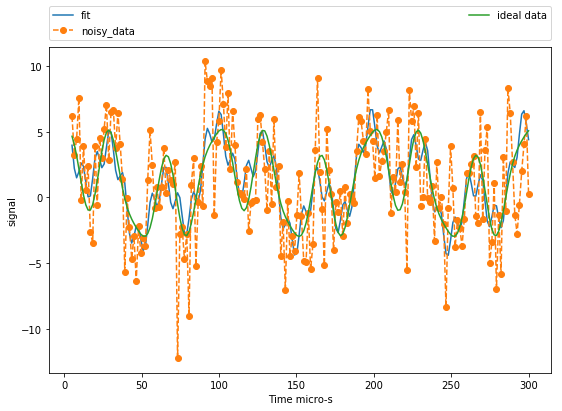

In [8]:
three_sine_offset_testing2()